# Speech Understanding
## Assignment 2
#### Question 2
### Akansha Gautam (M23CSA506)

# Import libraries

In [96]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import IPython.display as ipd
import librosa.display
import torchaudio
import torchaudio.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
import os

pd.set_option('display.max_colwidth', None)

# Set Device

In [97]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


# Task A

## Load Dataset

In [98]:
directory = '/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 2/dataset/Language Detection Dataset'

language_data = []

for root, xa, files in os.walk(directory):
    for file in files:
        if file == '.DS_Store':
            continue

        full_path = os.path.join(root, file)
        class_label = os.path.basename(root)
        language_data.append({"file_name": file, "file_path": full_path, "label": class_label})

language_df = pd.DataFrame(language_data)
language_df.head(4)


,file_name,file_path,label
0,14788.mp3,/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 2/dataset/Language Detection Dataset/Gujarati/14788.mp3,Gujarati
1,23124.mp3,/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 2/dataset/Language Detection Dataset/Gujarati/23124.mp3,Gujarati
2,24893.mp3,/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 2/dataset/Language Detection Dataset/Gujarati/24893.mp3,Gujarati
3,15496.mp3,/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 2/dataset/Language Detection Dataset/Gujarati/15496.mp3,Gujarati


## Exploratory Data Analysis

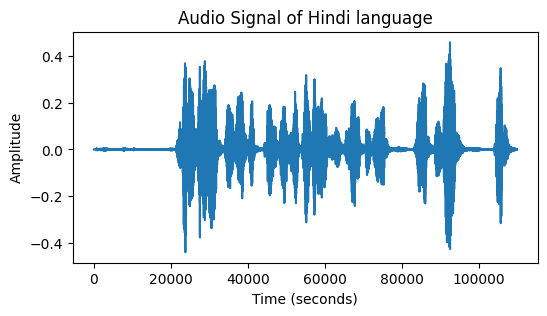

In [99]:
# Load mp3 file of Hindi language
file = language_df[language_df['label'] == 'Hindi']
file_path = file.iloc[0]['file_path']
label = file.iloc[0]['label']
x, _ = librosa.load(file_path)

plt.figure(figsize=(6,3))
plt.title(f"Audio Signal of {label} language")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.plot(x)
plt.show()

ipd.Audio(file_path)

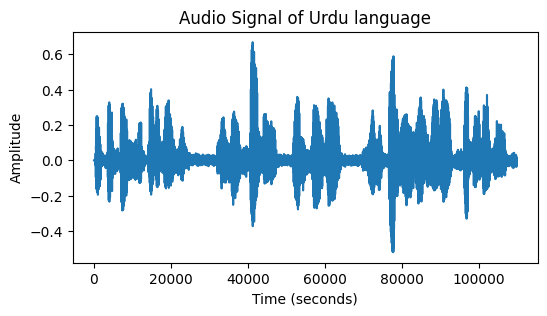

In [100]:
# Load mp3 file of Urdu language
file = language_df[language_df['label'] == 'Urdu']
file_path = file.iloc[3]['file_path']
label = file.iloc[0]['label']
x, _ = librosa.load(file_path)

plt.figure(figsize=(6,3))
plt.title(f"Audio Signal of {label} language")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.plot(x)
plt.show()

ipd.Audio(file_path)

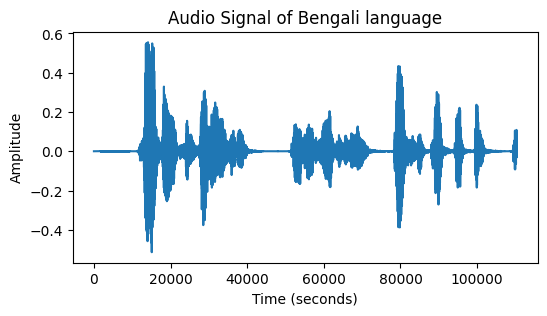

In [101]:
# Load mp3 file of Bengali language
file = language_df[language_df['label'] == 'Bengali']
file_path = file.iloc[32]['file_path']
label = file.iloc[0]['label']
x, _ = librosa.load(file_path)

plt.figure(figsize=(6,3))
plt.title(f"Audio Signal of {label} language")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.plot(x)
plt.show()

ipd.Audio(file_path)

In [102]:
# Show Language Dataframe information
language_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256833 entries, 0 to 256832
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   file_name  256833 non-null  object
 1   file_path  256833 non-null  object
 2   label      256833 non-null  object
dtypes: object(3)
memory usage: 5.9+ MB


/var/folders/12/7zfx6db53p5bf6btn6s9bqy40000gn/T/ipykernel_7118/4181290810.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=language_df, palette="husl")


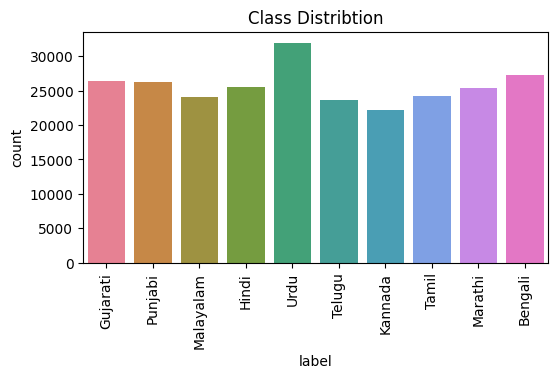

In [104]:
# Show the number of samples present of each class
plt.figure(figsize=(6, 3))
sns.countplot(x='label', data=language_df, palette="husl")
plt.title('Class Distribtion')
plt.xticks(rotation=90)
plt.show()

## Extract Mel-Frequency Cepstral Coefficients (MFCC) from each audio sample.

In [105]:
NUM_MFCC_COEFFICIENTS = 13
HOP_LENGTH = 512
FRAME_LENGTH = 2048
DURATION = 5

In [106]:
def extract_mel_frequency_cepstral_coefficients_features(audio_path, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, 
                                                         n_mfcc=NUM_MFCC_COEFFICIENTS, duration=DURATION):
    y, sr = librosa.load(audio_path, duration=duration)

    if y.size == 0:
        print(f"Empty audio file found: {audio_path}")
        return None
    
    if len(y) < frame_length:
        pad_length = frame_length - len(y)
        y = np.pad(y, (0, pad_length), mode='constant')

    y = librosa.util.normalize(y)
    y = librosa.effects.preemphasis(y)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length)
    return y, sr, mfcc

processed_data = []
label_counter = {}
for index, row in language_df.iterrows():
    file_name = row['file_name']
    file_path = row['file_path']
    label = row['label']

    if label not in label_counter:
        label_counter[label] = 0

    if label_counter[label] >= 5000:
        continue

    result = extract_mel_frequency_cepstral_coefficients_features(file_path)
    
    if result is None:
        continue

    waveform, sr, mfcc = result
    processed_data.append({
        "file_name": file_name,
        "file_path": file_path,
        "label": label,
        "waveform": waveform,
        "sampling_rate": sr,
        "mfcc": mfcc
    })

    label_counter[label] += 1

lang_df = pd.DataFrame(processed_data)
print(f"Language Dataframe Shape: {lang_df.shape}")
lang_df.head(2)


Language Dataframe Shape: (50000, 6)


file_name  \
0  14788.mp3   
1  23124.mp3   

                                                                                                                      file_path  \
0  /Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 2/dataset/Language Detection Dataset/Gujarati/14788.mp3   
1  /Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 2/dataset/Language Detection Dataset/Gujarati/23124.mp3   

      label  \
0  Gujarati   
1  Gujarati   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        waveform  \
0  [1.9385147e-12, -6.6993535e-13, -3.5263112e-13, 4.6581743e-13, -4.3170212e-13, 5.6280696e-13, -1.2564635e-12, 6.441735e-13, -1.6451868e-13, 1.8798496e-13, -3.160289e-13, 7.460731e-13, -3.532688e-13, -8.340713e-14, -6.9786527e-13, 7.863738e-13, 1.4768422e-13, 4.8386344e-13, 2.6884137e-13, -1.4436835e-13, -7.282185e-14, 4.2188198e-13, 1.7905756e-13, -3.7750028e-13, -7.4683825e-13, -1.4839839e-12, 5.3054024e-14, 1.7905754e-12, -1.164129e-12, 8.1570655e-13, 1.0450125e-12, -1.1171966e-12, 1.1095446e-13, -1.9806007e-13, 2.6150818e-13, -5.147904e-13, 2.6042414e-13, -1.8301102e-14, -4.4190454e-14, 5.2378154e-13, -8.153399e-13, -6.848569e-14, 3.348561e-13, -5.2738434e-13, 2.7560864e-13, 4.340057e-13, -8.432499e-13, 3.236491e-13, 5.8400794e-13, 2.2829256e-13, -3.7581638e-13, -2.6044808e-13, -1.323044e-13, 5.6285873e-13, 1.7322884e-13, -5.9706173e-13, -7.407884e-13, 7.340374e-14, 1.0920247e-12, 1.4440817e-13, -1.7943218e-13, -8.689121e-13, 7.9093215e-13, -9.8440204e-14, 7.854031e-14, -4.405095e-13, 2.3130033e-13, 3.6696384e-13, 6.357283e-14, 1.2106597e-13, -2.1176715e-13, 1.1801286e-13, 2.64359e-13, -6.4999915e-13, 6.2234733e-13, -5.895581e-13, -5.116155e-13, 1.823319e-13, -1.9165569e-13, -4.4852577e-13, 6.1261e-13, -4.568648e-13, 5.4246267e-14, 1.5442297e-13, 1.0758647e-12, -2.0489686e-14, -1.695149e-12, 2.428944e-12, -4.2562064e-13, -3.745419e-13, 9.902975e-13, -1.2611787e-12, -7.7528506e-13, 1.5045707e-13, 1.0713676e-12, -8.7960206e-13, -8.428493e-14, 3.2818748e-13, -2.4873785e-13, 1.786869e-13, ...]   
1     [-8.3538306e-14, 1.6069896e-14, -3.461899e-14, 6.136921e-14, -2.1181e-14, 5.901577e-14, -2.7235282e-14, -7.121415e-14, -1.9474307e-14, 4.8254606e-14, 3.3594973e-14, -8.215498e-14, 8.4238944e-14, 2.7540692e-14, 6.068653e-14, -2.0027635e-13, 1.5202623e-13, -5.4614313e-15, 3.743953e-14, -1.9862353e-13, 1.4027248e-13, 2.24206e-14, 1.8116133e-13, -1.9431188e-13, -1.7160383e-13, 2.0408496e-13, -1.3459547e-13, 4.8146803e-14, -1.5018926e-14, -6.036316e-14, 4.47513

## Generate and visualize MFCC spectrograms for a representative set of samples from at least 3 languages of your choice

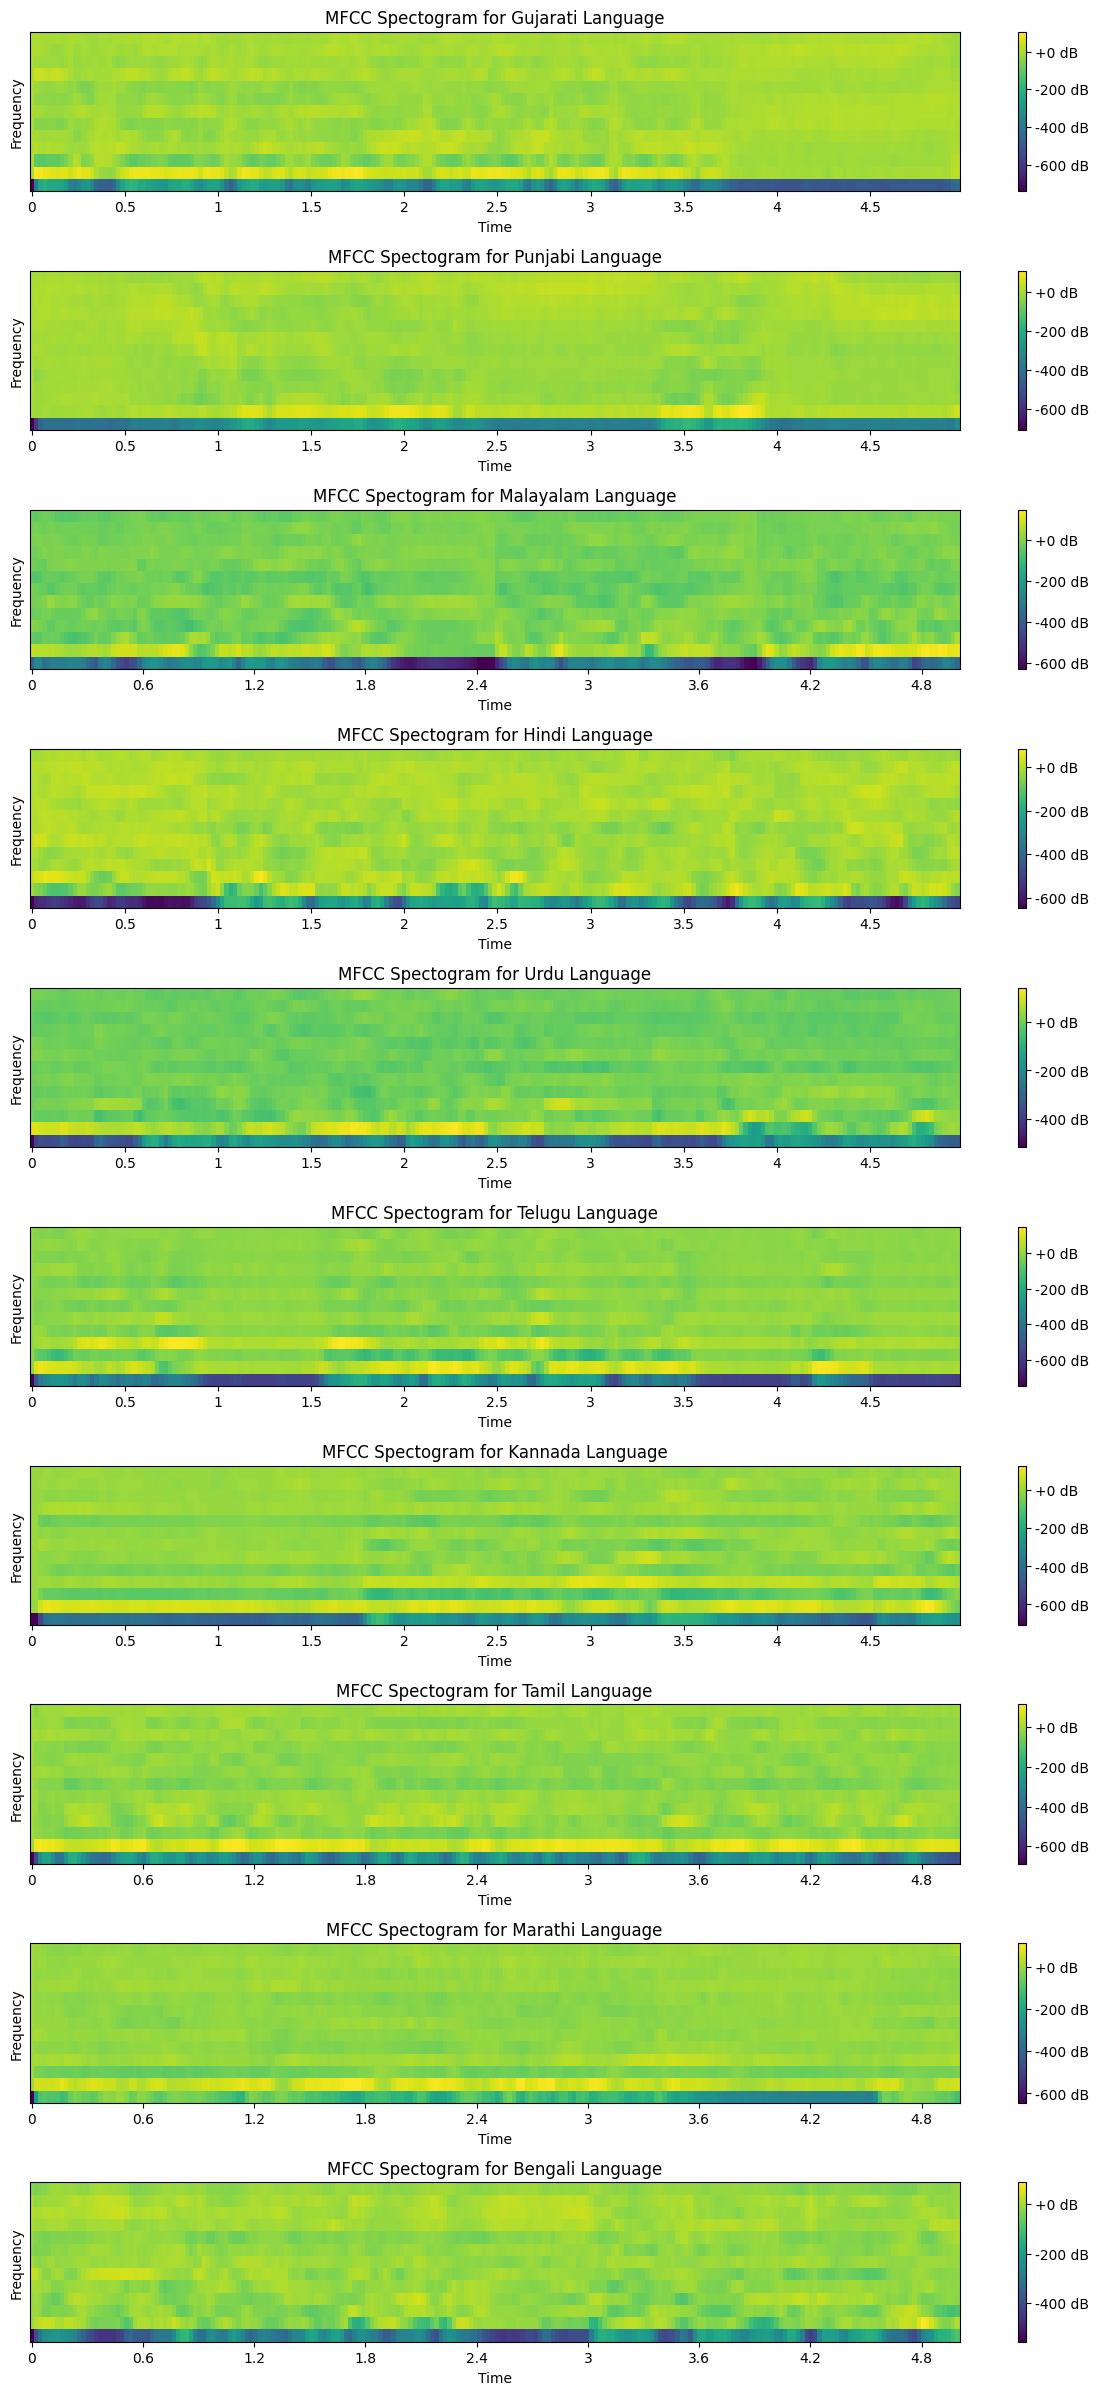

In [107]:
plt.figure(figsize=(15, 30))
label_counter = {}
index = 0

for _, row in lang_df.iterrows():
    label = row['label']

    if label not in label_counter:
        label_counter[label] = 0

    if label_counter[label] >= 1:
        continue

    file_name = row['file_name']
    mfcc = row['mfcc']

    num_frames = mfcc.shape[1]
    t = librosa.frames_to_time(range(num_frames), hop_length=HOP_LENGTH)

    plt.subplot(10, 1, index + 1)
    librosa.display.specshow(mfcc, cmap='viridis', x_axis="time")
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"MFCC Spectogram for {label} Language")
    plt.ylabel(f"Frequency")

    label_counter[label] += 1
    index += 1

plt.subplots_adjust(hspace=0.5)
plt.show()


## Perform a statistical analysis (e.g., compute the mean and variance of MFCC coefficients) to quantify differences between languages.

In [108]:
label_counter = {}
mfcc_stats = []
index = 0
target_frames = 215

unique_labels = lang_df['label'].unique()

for label in unique_labels:
    lang_label_df = lang_df[lang_df['label'] == label]

    mfcc = lang_label_df['mfcc']
    processed_mfcc = []

    for x in mfcc:
        x = np.array(x)
    
        if x.shape[1] < target_frames:
            pad_width = target_frames - x.shape[1]
            x = np.pad(x, ((0,0), (0, pad_width)), mode='constant')
        
        elif x.shape[1] > target_frames:
            x = x[:, :target_frames]

        processed_mfcc.append(x)

    mfcc_array = np.stack(processed_mfcc)
    num_samples = mfcc_array.shape[0]
    mfcc_combined = mfcc_array.reshape(13, num_samples * 215)

    mean_mfcc = np.mean(mfcc_combined, axis=1)
    var_mfcc = np.var(mfcc_combined, axis=1)

    mfcc_stats.append({
        "mean": mean_mfcc,
        "variance": var_mfcc,
        "label": label
    })
    


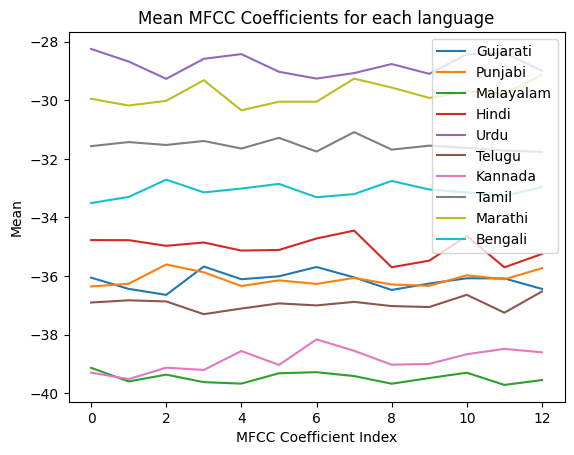

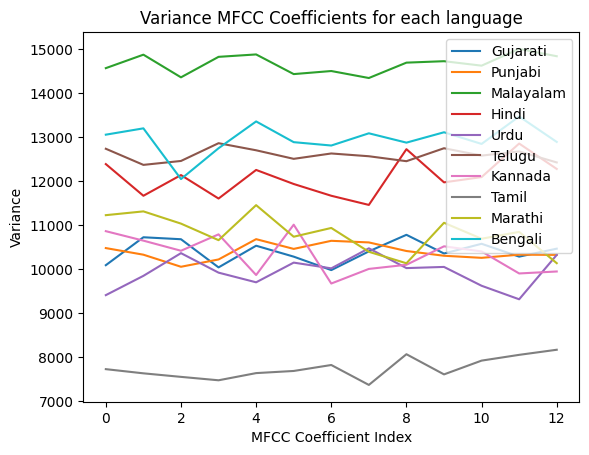

In [110]:
for row in mfcc_stats:
    plt.plot(row['mean'], label=f"{row['label']}")

plt.title('Mean MFCC Coefficients for each language')
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Mean')
plt.legend()
plt.show()

for row in mfcc_stats:
    plt.plot(row['variance'], label=f"{row['label']}")

plt.title('Variance MFCC Coefficients for each language')
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Variance')
plt.legend()
plt.show()

## Task B

In [114]:
target_frames = 215

features_df = lang_df[['mfcc']].copy()
mfcc = features_df['mfcc']

processed_mfcc = []
for x in mfcc:
    x = np.array(x)

    if x.shape[1] < target_frames:
        pad_width = target_frames - x.shape[1]
        x = np.pad(x, ((0,0), (0, pad_width)), mode='constant')
    
    elif x.shape[1] > target_frames:
        x = x[:, :target_frames]

    processed_mfcc.append(x.flatten())

features_df = np.array(processed_mfcc)

label_df = lang_df[['label']]

print(f"MFCC features shape: {features_df.shape}")
print(f"MFCC label shape: {label_df.shape}")

MFCC features shape: (50000, 2795)
MFCC label shape: (50000, 1)


/Users/akanshagautam/Documents/MTech/ml_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X train shape:  (40000, 2795)
X test shape:  (10000, 2795)
Y train shape:  (40000,)
Y test shape:  (10000,)
Classification Report:
               precision    recall  f1-score   support

     Bengali       0.86      0.91      0.89      1000
    Gujarati       0.44      0.44      0.44      1000
       Hindi       0.90      0.97      0.93      1000
     Kannada       0.97      0.95      0.96      1000
   Malayalam       0.95      0.96      0.96      1000
     Marathi       0.88      0.89      0.88      1000
     Punjabi       0.44      0.43      0.44      1000
       Tamil       0.94      0.93      0.93      1000
      Telugu       0.95      0.92      0.93      1000
        Urdu       0.86      0.83      0.85      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

Confusion matrix:
 [[908   0  29   1   6  17   5   2  11  21]
 [ 11 438   3   1   3   2 523   1   4  14]
 [ 1

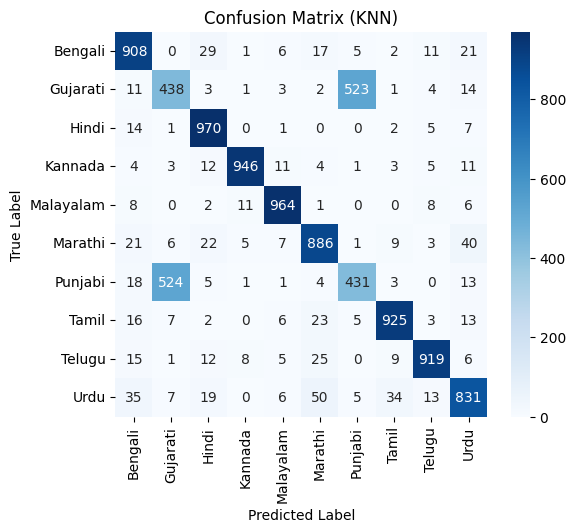

In [115]:
label = label_df.values

label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(label)

X_train, X_test, y_train, y_test = train_test_split(features_df, label_encoded, test_size=0.2, random_state=45, stratify=label_encoded)
print("X train shape: ", X_train.shape)
print("X test shape: ", X_test.shape)
print("Y train shape: ", y_train.shape)
print("Y test shape: ", y_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifier = SVC(kernel='rbf', random_state=45, decision_function_shape='ovo')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

calc_classification_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", calc_classification_report)

calc_confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", calc_confusion_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(calc_confusion_matrix, annot=True, cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (KNN)") 
plt.show()
